**Predict sales prices and practice feature engineering, RFs, and gradient boosting**

In [1]:
import matplotlib
import os
import warnings
from scipy import stats

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet
from matplotlib.pyplot import figure
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler

In [2]:
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
%matplotlib inline

In [3]:
# enter your Kaggle credentionals here
# os.environ['KAGGLE_USERNAME']="yanzkholik"
# os.environ['KAGGLE_KEY']="c4122a918f06926cbc989dccea42a449"

In [4]:
df_train = pd.read_csv('data/train/train.csv')
df_test = pd.read_csv('data/test/test.csv')

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [6]:
df_train.SalePrice.describe()

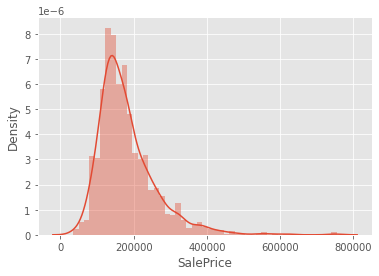

In [7]:
sns.distplot(df_train.SalePrice)

In [8]:
print(f"Skewness : {df_train.SalePrice.skew()}")
print(f"Kurtosis : {df_train.SalePrice.kurt()}")

Skewness : 1.8828757597682129
Kurtosis : 6.536281860064529


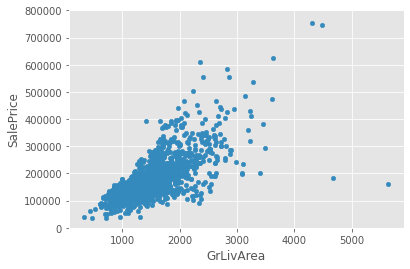

In [9]:
data = pd.concat([df_train.SalePrice, df_train.GrLivArea], axis=1)
data.plot.scatter(x='GrLivArea', y='SalePrice', ylim=(0, 800000))

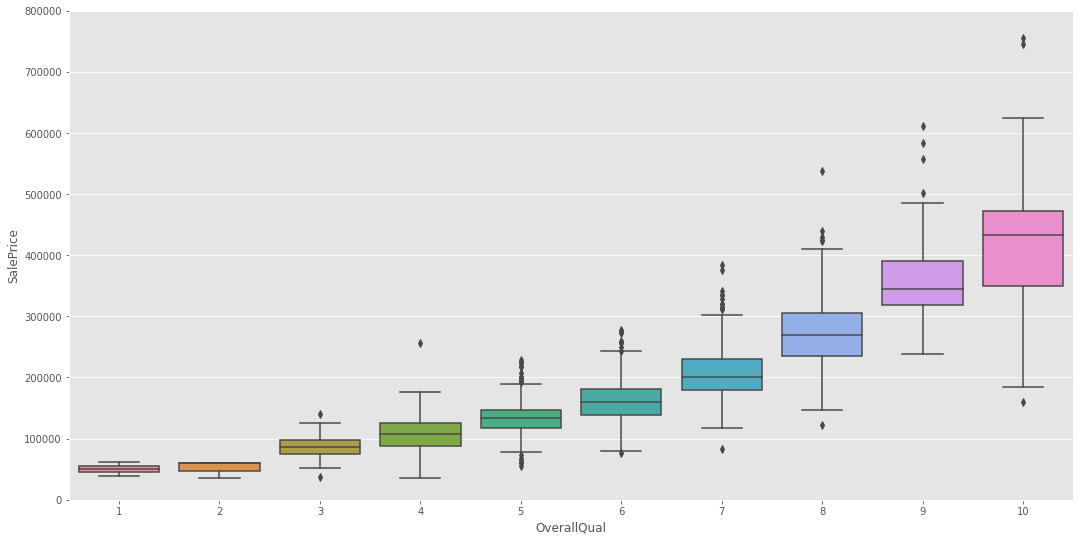

In [10]:
data = pd.concat([df_train.SalePrice, df_train.OverallQual], axis=1)
f, ax = plt.subplots(figsize=(18, 9))
fig = sns.boxplot(x='OverallQual', y='SalePrice', data = data)
fig.axis(ymin=0, ymax=800000)

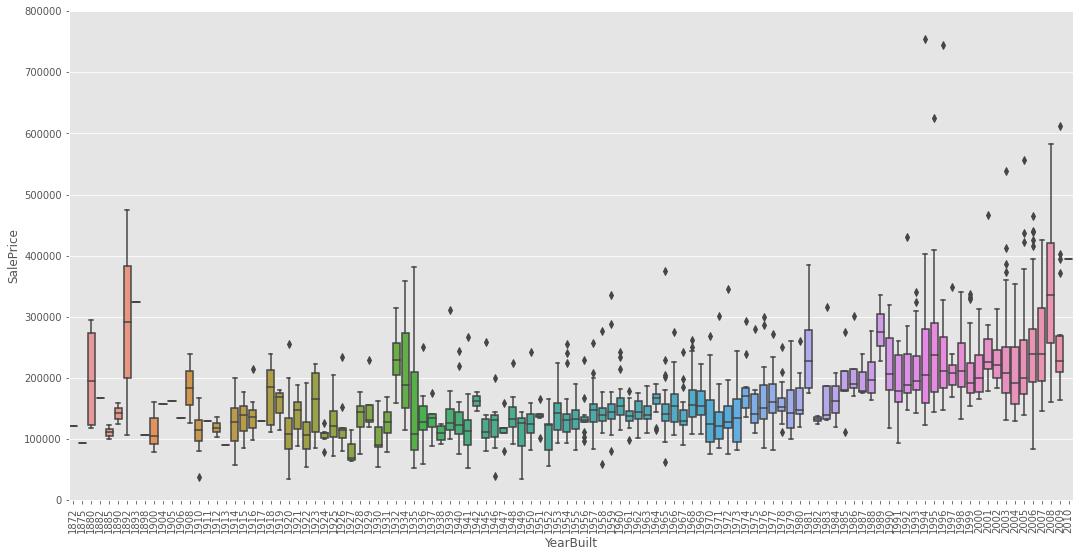

In [11]:
data = pd.concat([df_train.SalePrice, df_train.YearBuilt], axis = 1)
f, ax = plt.subplots(figsize=(18, 9))
fig = sns.boxplot(x ='YearBuilt', y='SalePrice', data = data)
fig.axis(ymin = 0, ymax= 800000)
plt.xticks(rotation=90)

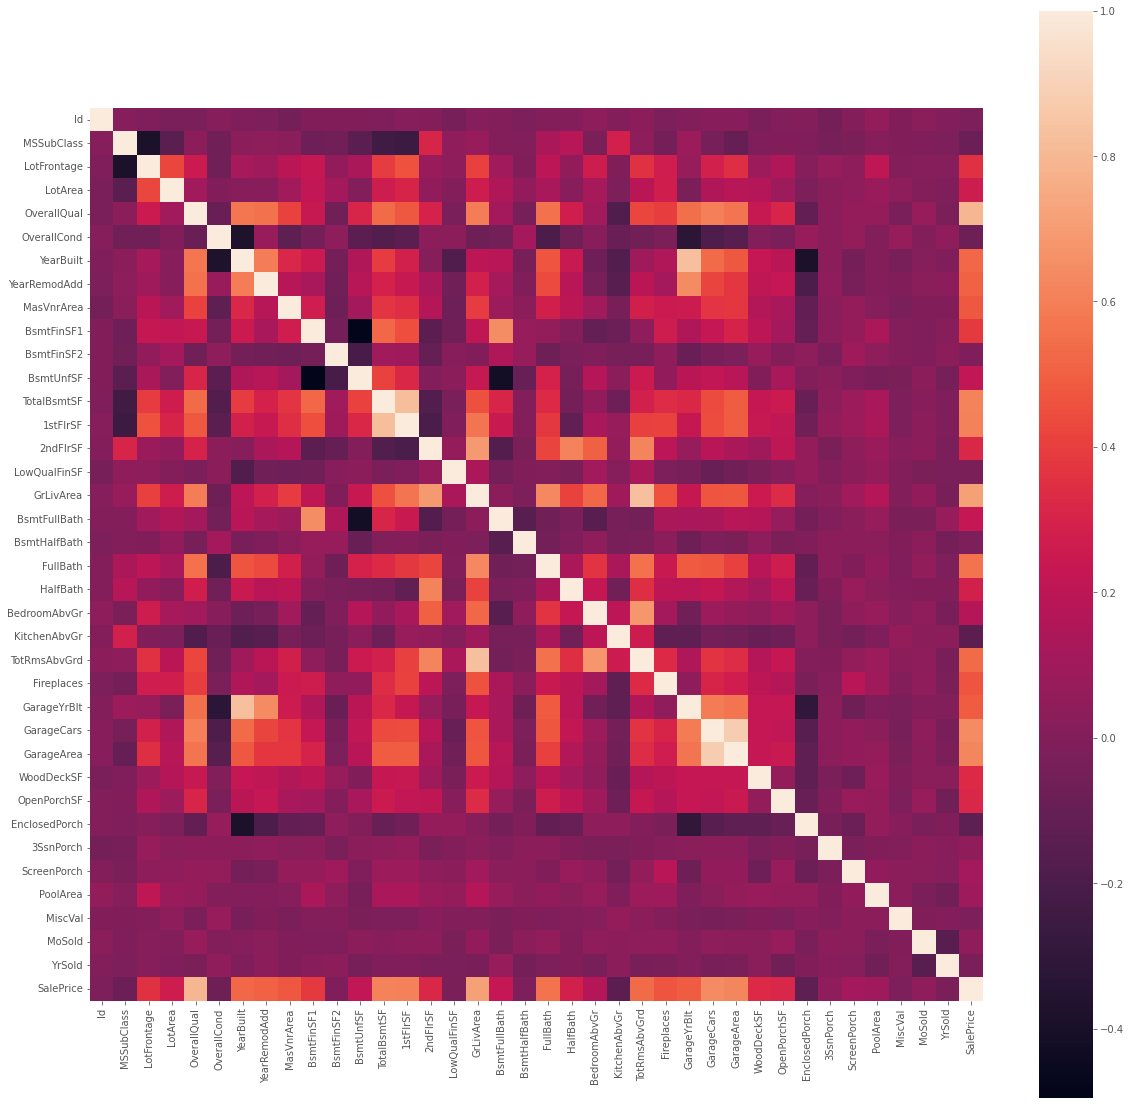

In [12]:
dta_corr = df_train.corr()
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(dta_corr, square=True, ax=ax)

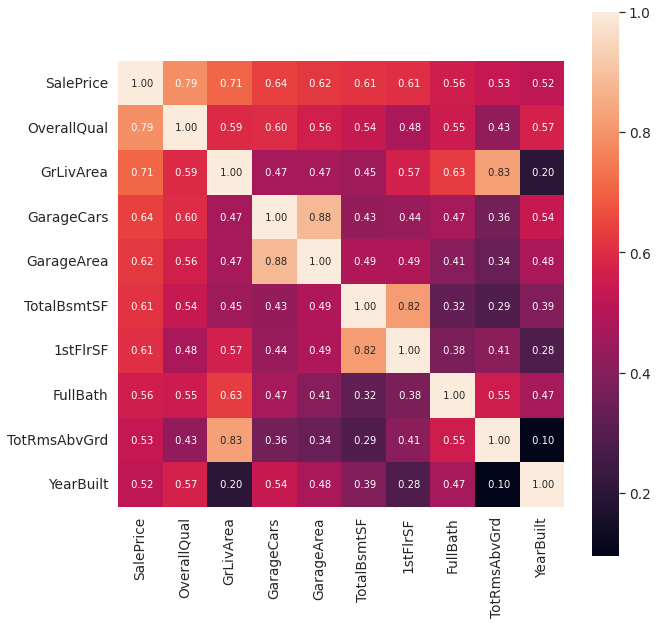

In [13]:
cols = dta_corr.nlargest(10, 'SalePrice')['SalePrice'].index

cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
fig, ax = plt.subplots(figsize=(10, 10))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt=' .2f', annot_kws={'size':10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

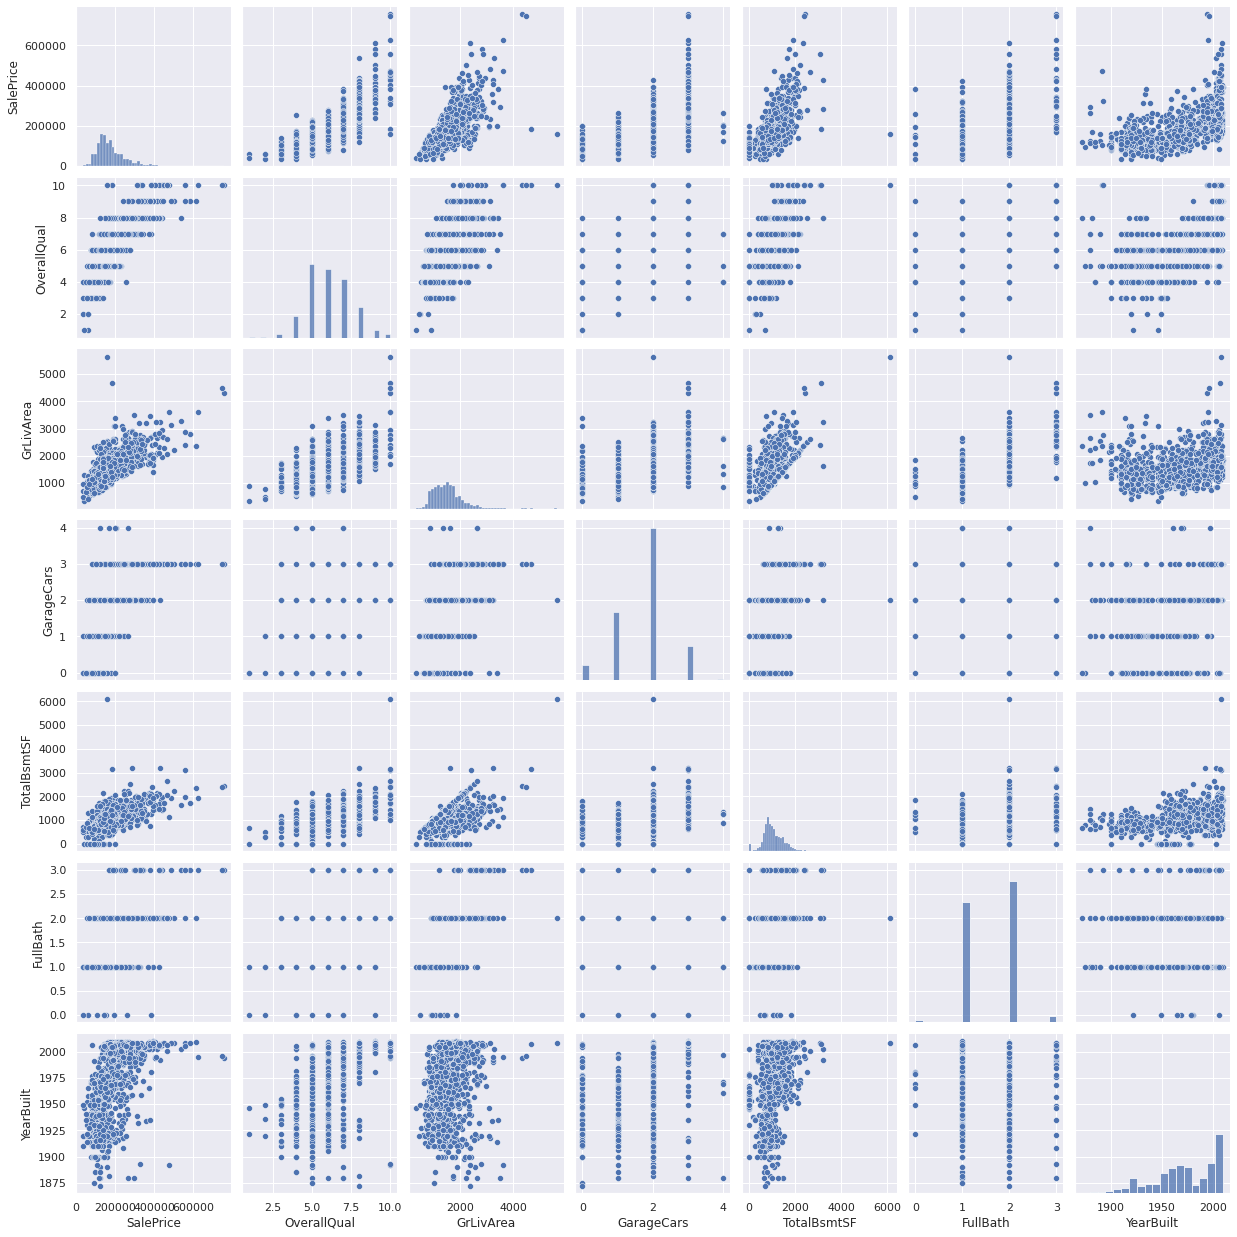

In [14]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train[cols], size=2.5)
plt.show()

In [15]:
#count missing data
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479


In [16]:
#dealing with missing data
df_train = df_train.drop((missing_data[missing_data['Total'] > 1]).index,1)
df_train = df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index)

In [17]:
df_train.isnull().sum().max()

0

In [18]:
saleprice_scaled = StandardScaler().fit_transform(df_train.SalePrice[:, np.newaxis])
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print(f"low range: {low_range}")
print(f"high range: {high_range}")

low range: [[-1.83820775]
 [-1.83303414]
 [-1.80044422]
 [-1.78282123]
 [-1.77400974]
 [-1.62295562]
 [-1.6166617 ]
 [-1.58519209]
 [-1.58519209]
 [-1.57269236]]
high range: [[3.82758058]
 [4.0395221 ]
 [4.49473628]
 [4.70872962]
 [4.728631  ]
 [5.06034585]
 [5.42191907]
 [5.58987866]
 [7.10041987]
 [7.22629831]]


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


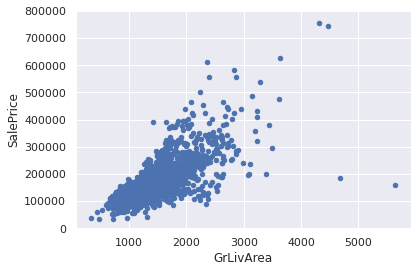

In [19]:
#bivariate analysis saleprice/grlivarea
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

In [20]:
#deleting points
df_train.sort_values(by = 'GrLivArea', ascending = False)[:2]
df_train = df_train.drop(df_train[df_train['Id'] == 1299].index)
df_train = df_train.drop(df_train[df_train['Id'] == 524].index)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


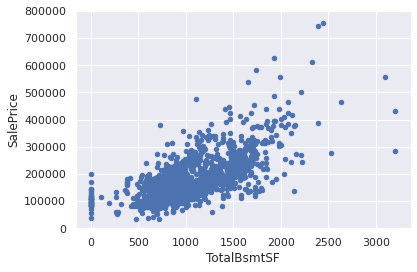

In [21]:
#bivariate analysis saleprice/grlivarea
var = 'TotalBsmtSF'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

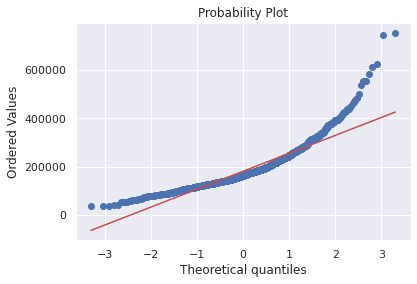

In [22]:
#histogram and normal probability plot
sns.distplot(df_train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

In [23]:
#applying log transformation
df_train['SalePrice'] = np.log(df_train['SalePrice'])

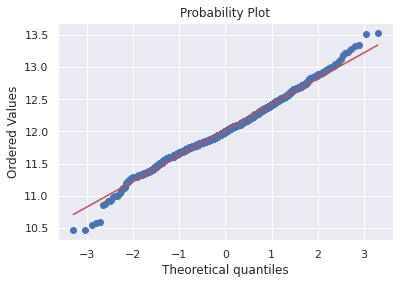

In [24]:
#transformed histogram and normal probability plot
sns.distplot(df_train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

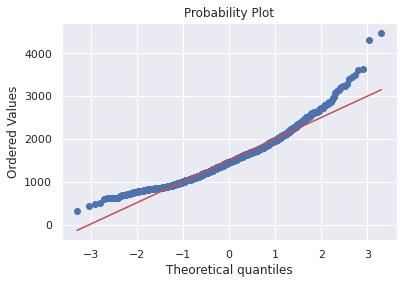

In [25]:
#histogram and normal probability plot
sns.distplot(df_train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['GrLivArea'], plot=plt)

In [26]:
#data transformation
df_train['GrLivArea'] = np.log(df_train['GrLivArea'])

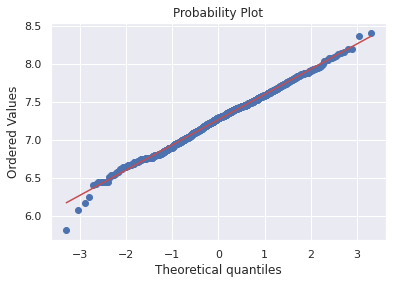

In [27]:
#transformed histogram and normal probability plot
sns.distplot(df_train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['GrLivArea'], plot=plt)

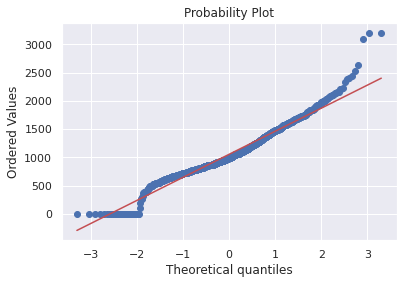

In [28]:
#histogram and normal probability plot
sns.distplot(df_train.TotalBsmtSF, fit=norm)
fig = plt.figure()
res = stats.probplot(df_train.TotalBsmtSF, plot=plt)